In [2]:

#This code simulates sarcomere quick-release experiments based on the
# reduced 4-state XB model presented in "Dynamics of cross-bridge cycling, 
# ATP hydrolysis, force generation, and deformation in cardiac muscle". For
# model equations please refer to the manuscript.
# Disclaimer: This code is free to use, edit, reproduce as long as the
# source is cited.
#            P <--> 1 (t,s)
#            |      |
#      (t,s) 3 <--> 2 (t,s)
# This code we produce figure 4 and 6 of the following paper: 
# ” Dynamics of cross-bridge cycling, ATP hydrolysis, force generation, and deformation in
# cardiac muscle” Tewari et al. 2016
# Original code is Written MATLAB by: Shivendra Tewari
# E-mail: TewariSG@gmail.com

# The code was rewritten in python by: Bahador Marzban
# E-mail: bmarzban@med.umich.edu

import numpy as np
import time
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
import math


def heav(x):
    return 1*(x>0)

def passiveForces(SL,SL_rest,kpe1):
    SLset = 2.2 # set Set sarcomere length, Units: um 
    timrel = 0.1 # Time of sarcomere release, Units: ms
    # Passive Force formulation adopted from Rice etal Rice etal (Biophys J. 2008 Sep;95(5):2368-90)
    # Function to calculate the passive forces of the muscle
    # The passive force is a function of the sarcomere length
    beta = 3.5 # um
    PCon_titin = kpe1*beta*0.002 #
    PExp_titin = 10 #(um-1)
    SL_collagen = 2.25 #(um)
    PCon_collagen = kpe1*beta*0.02 #
    PExp_collagen  = 70 #(um-1)

    # Passive forces: Trabeculae 
    PF_titin = np.sign(SL-SL_rest)*PCon_titin* math.exp(np.fabs(SL-SL_rest)*PExp_titin-1)
    dPF_titin = (PCon_titin*PExp_titin* math.exp(PExp_titin*np.abs(SL - SL_rest) - 1)*np.sign(SL - SL_rest)**2);

    PF_collagen = heav(SL-SL_collagen)*PCon_collagen* math.exp(PExp_collagen*(SL-SL_collagen)-1);
    dPF_collagen = heav(SL-SL_collagen)*PCon_collagen*PExp_collagen* math.exp(PExp_collagen*(SL-SL_collagen)-1);

    PF = PF_titin + 1*PF_collagen; #Trabeculae
    dPF = dPF_titin + dPF_collagen;
    passive = [PF,dPF]
    return passive

def Model_XB( y,t,TmpC,MgATP,Pi,MgADP,F_load,ode_solve):

    SLset = 2.2 # set Set sarcomere length, Units: um 
    timrel = 0.1 # Time of sarcomere release, Units: ms
    ## Constants and parameters
    # Estimated parameters from Pi and ATP data (Average of N=21 GA runs)
    par = [4.5397e+02 ,  1.2521e+02 ,  4.1169e+01 ,  1.7553e+01 ,  1.5928e+02 ,  1.5372e+00  , 8.7750e+01,   1.5137e+01 ,  1.0060e+01,   5.0247e+01 ,  9.9383e-03,   4.0067e+00 ,  7.2899e+02  , 5.0129e-01 ,   1.1370e+03,   2.5464e+02,   1.9066e+04 ,  5.9698e-01]
    # Estimated Q10s from individual mouse Ref[20] in dynamic paper
    Q10s = [1.4382e+00 ,   3.0265e+00  , 1.0717e+00 ,  1.3403e+00 ,  1.4782e+00 ,  1.4413e+00]

    alpha1 = 1*par[7]
    alpha2 = 1*par[8]
    alpha3 = 1*par[9]
    s3 = par[10]
    K_Pi = par[11]
    K_T = par[17]
    K_D = 0.194 # MgADP dissociation constant from Yamashita etal (Circ Res. 1994; 74:1027-33).
    g1 = (MgADP/K_D)/(1 + MgADP/K_D + MgATP/K_T) # is k-2_Bar in the dynamic paper. with out k-2 

    g2 = (MgATP/K_T)/(1 + MgATP/K_T + MgADP/K_D) # is k3_bar in the dynamics paper. with out k3

    f1 = (Pi/K_Pi)/(1 + Pi/K_Pi) # is the k_d_bar in the dynamics paper. without kd

    f2 = 1/(1 + Pi/K_Pi) # is the k1_bar in the dynamic paper. 

    # I think since the if the data we have is in other temprature. we can calculate all the
    # reaction rates from 17 C in the following. # for current input which is
    # Tmpc = 17. it will not make any changes to the reaction rates.


    kf = par[0]*Q10s[0]**((TmpC-17)/10) #ka in the paper
    kb = par[1]*f1*Q10s[0]**((TmpC-17)/10) #kd_bar in the paper
    k1 = par[2]*f2*Q10s[0]**((TmpC-17)/10)
    k_1 = par[3]*Q10s[0]**((TmpC-17)/10)
    k2 = par[4]*1*Q10s[1]**((TmpC-17)/10)
    k_2 = par[5]*1*Q10s[0]**((TmpC-17)/10)*g1
    k3 = par[6]*Q10s[0]**((TmpC-17)/10)*g2


    kpe2 = par[12]*Q10s[2]**((TmpC-17)/10)
    eta = par[13]*Q10s[2]**((TmpC-17)/10)
    kstiff1 = par[14]*Q10s[3]**((TmpC-17)/10)
    kpe1 = par[15]*Q10s[4]**((TmpC-17)/10)
    kstiff2 = par[16]*Q10s[5]**((TmpC-17)/10)

    SL_max = 2.4
    SL_min = 1.4
    SL_rest = 1.9 # (um)

    ## State Variables
    P1o = y[0]
    P1i = y[1]
    P1w = y[2]

    P2o = y[3]
    P2i = y[4]
    P2w = y[5]

    P3o = y[6]
    P3i = y[7]
    P3w = y[8]
    Pu = 1 - P1o - P2o - P3o
    SL = y[9]

    ## Stretch-sensitive rates
    f_alpha1o = (P1o - alpha1*P1i + 0.5*(alpha1*alpha1)*P1w)
    f_alpha1i = (P1i - alpha1*P1w)

    alpha0 = 1*alpha1
    f_alpha0o = (P2o + alpha0*P2i + 0.5*alpha0*alpha0*P2w)
    f_alpha0i = (P2i + alpha0*P2w)

    f_alpha2o = (P2o - alpha2*P2i + 0.5*(alpha2*alpha2)*P2w)
    f_alpha2i = (P2i - alpha2*P2w)

    alpha2b = 0; 
    f_alphao = (P3o + alpha2b*P3i + 0.5*(alpha2b*alpha2b)*P3w)
    f_alphai = (P3i + alpha2b*P3w)

    f_alpha3o = (P3o + alpha3*(s3*s3*P3o + 2*s3*P3i + P3w))
    f_alpha3i = (P3i + alpha3*(s3*s3*P3i + 2*s3*P3w))

    ## Compute Active & Passive Force
    # Active Force
    dr = 0.01 # Power-stroke Size; Units: um # or 10 nm
    B_process = kstiff2*dr*P3o  # Force due to XB cycling
    C_process = kstiff1*(P2i+P3i) # Force due to stretching of XBs
    F_active = (B_process + C_process)

    # Non-linear Passive force; Adopted from Rice etal (Biophys J. 2008 Sep;95(5):2368-90)
    [F_passive,dFpassive] = passiveForces(SL,SL_rest,kpe1) 
    if t<timrel :
        [F_preload,dFpreload] = passiveForces(SLset,SL_rest,kpe1)

    else:
        [F_preload,dFpreload] = passiveForces(SLset,SL_rest,0.0*kpe1)
    
    
    F_afterload = heav( t - timrel) * (F_load)

    f_myofibril = 0.45 # Percent Myofibril in Muscle from Palmer etal (Mol Cell Biochem. 2004 Aug;263(1-2):73-80)
    Ftotal = f_myofibril * (F_active + F_passive)#

    dFxb = kstiff1*(P2o + P3o)
    dfxb = heav(t-timrel)*(kstiff1*(- k3*(P3i + alpha3*(P3i*s3**2 + 2*P3w*s3)) + k1*(P1i - P1w*alpha1) - k_1*(P2i + P2w*alpha1)) - dr*kstiff2*(P3o*k_2 + k3*(P3o + alpha3*(P3o*s3**2 + 2*P3i*s3 )+ P3w) - k2*((P2w*alpha2**2)/2 - P2i*alpha2 + P2o)))
    intf = heav(t-timrel)*(-Ftotal + F_afterload + f_myofibril*F_preload); 
    den = 1 + dFxb/kpe2 - dFpreload/kpe2 + dFpassive/kpe2;
    ## XB ODEs
    dSL = ((intf/eta) - dfxb/kpe2)*heav(SL-SL_min)*heav(SL_max-SL)/den;
    dP1o = kf*Pu   - kb*P1o - k1*f_alpha1o + k_1*f_alpha0o;
    dP1i = 1*dSL*P1o - kb*P1i - k1*f_alpha1i + k_1*f_alpha0i;
    dP1w = 2*dSL*P1i - kb*P1w - k1*P1w + k_1*P2w;

    dP2o =         - k_1*f_alpha0o - k2*f_alpha2o + k_2*f_alphao + k1*f_alpha1o;
    dP2i = 1*dSL*P2o - k_1*f_alpha0i - k2*f_alpha2i + k_2*f_alphai + k1*f_alpha1i;
    dP2w = 2*dSL*P2i - k_1*P2w       - k2*P2w + k_2*P3w + k1*P1w;

    dP3o =         + k2*f_alpha2o - k_2*f_alphao - k3*f_alpha3o;
    dP3i = 1*dSL*P3o + k2*f_alpha2i - k_2*f_alphai - k3*f_alpha3i;
    dP3w = 2*dSL*P3i + k2*P2w       - k_2*P3w - k3*P3w;

    dYdT = [dP1o, dP1i, dP1w, dP2o, dP2i, dP2w, dP3o, dP3i, dP3w, dSL]
    if ode_solve==1: 
        return dYdT
    else:
        return dSL,Ftotal 
    
start = time.time()
SLset = 2.2 # set Set sarcomere length, Units: um 
timrel = 0.1 # Time of sarcomere release, Units: ms
# Set temperature and initial SL
TmpC = 17 
SL0 = 2.2 # Initial length of the sarcomere um

# Set metabolite concentrations, 
MgATP = 5.0 
MgADP = 0.0 
Pi = 0.0 
# Experimental conditions from Palmer etal J Mol Cell Cardiol. 2013 Apr;57:23-31


init = np.zeros(10)
init[9] = SL0
Fmax= 28.55


In [3]:
F_load = np.arange(0,1.05,0.05)* Fmax


In [4]:
mm = len(F_load)

vm = np.zeros((mm))
tspan = np.arange(0,0.4005,0.0005)
#print(F_afterload )
nn = len(tspan)
dSL = np.zeros((nn,mm))
SL_all = np.zeros((nn,mm))
Ftotal = np.zeros((nn,mm))

In [5]:

ts = 291 
X = np.arange(ts-10,ts+11,1) # time-points at which the average slope of sliding velocity is calculated i.e. between 40 to 50 ms after release


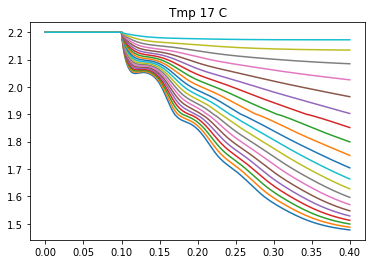

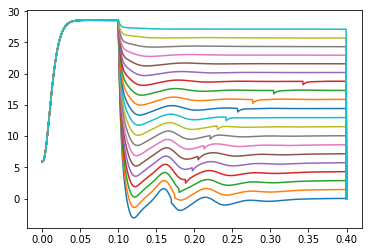

In [6]:
for j in range(1,mm):

   # AA = Model_XB(0.25,init,TmpC,MgATP,Pi,MgADP,F_load)
    y = odeint(Model_XB,init,tspan,args = (TmpC,MgATP,Pi,MgADP,F_load[j-1],1))
    SL = y[:,9]
    for i in range (1,nn):
        dSL[i-1][j-1],Ftotal[i-1][j-1]= Model_XB(y[i-1,:],tspan[i-1],TmpC,MgATP,Pi,MgADP,F_load[j-1],0)
        
        vm[j-1] = np.mean(dSL[X-1,j-1]/SL0)
    Ftotal_load = Ftotal[:,j-1]
    plt.figure(3)
    plt.title('Tmp 17 C')
    plt.plot(tspan,SL)
    #print (vm)
    plt.figure(4)
    plt.plot(tspan,Ftotal_load)
    #print (Ftotal.shape)
    #print (tspan)
    

In [7]:
endtime = time.time()
print(endtime - start)

2.4771180152893066


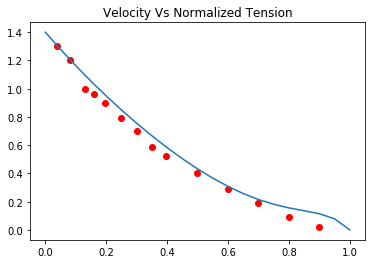

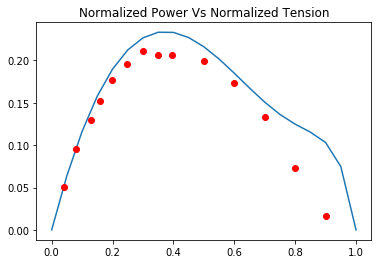

In [8]:
## Plots Data from Palmer etal J Mol Cell Cardiol. 2013 Apr;57:23-31
data_x = np.array([0.0391,    0.0797,    0.1300,    0.1580,    0.1970,    0.2480,    0.3010,    0.3490,    0.3960,    0.4990,    0.5990,    0.7000,    0.8000,    0.9000])
data_y = np.array([1.3000,    1.2000,    1.0000,    0.9600,    0.9000,    0.7900,    0.7000,    0.5900,    0.5200,    0.4000,    0.2900,    0.1900,    0.0910,    0.0180])
plt. figure(1)
plt.title('Velocity Vs Normalized Tension')
plt.plot(data_x,data_y,'ro')
plt.plot(F_load/Fmax, -vm)
#fig, axs = plt.figure(1)
#plt.axis('equal')
plt. figure(2)
plt.title('Normalized Power Vs Normalized Tension')
normal_power = data_y * data_x;
plt.plot(F_load/Fmax, (-vm * F_load) / Fmax)
plt.plot(data_x,normal_power,'ro')

In [9]:
#figure(3)
